# Clean up for your vacation images

In [1]:
# Define global variables, are explained below

IMAGES = './images/' # path to the images
IMAGES_PREPROCESSED = './preprocessed/' # not used at the moment
IMAGES_PROCESSED = './processed/' # output destination
HASH_DIM = (8, 8)

In [18]:
import glob
import os
import shutil

import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats as sts
from sklearn.linear_model import LogisticRegression

import spring_cleaning as sc # outsourced code

# How many correlations exist between images?

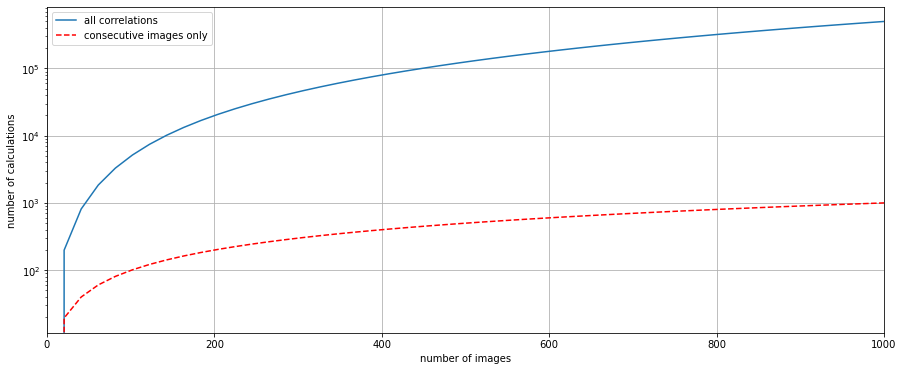

In [3]:
# function increases steeply, thus we make the assumption that only 
# consecutive images are related to each other

def corr(n):
    return n*(n-1)/2

n_max = 1000
n = np.linspace(0, n_max)
plt.figure(figsize=(15, 6))
plt.plot(n, corr(n), label='all correlations')
plt.plot(n, n-1, 'r--', label='consecutive images only')
plt.xlabel('number of images')
plt.ylabel('number of calculations')
plt.grid()
plt.legend()
plt.xlim([0, n_max])
plt.semilogy();

# Pipeline

In [3]:
# Load images and meta data

dict_files = sc.read_files(path=IMAGES, ext='jpg')

df = pd.DataFrame(dict_files, columns=['file', 'creation_date'])
df['creation_date'] = pd.to_numeric(df['creation_date'], downcast='integer')

# For ranking of images, we need some intrinsic measure for consecutiveness
# 'Creation Date' of images is a good measure
# 'File Name' as well, if pictures are taken from one and the same camera

# alternatively, sort by Filename: df.sort_values(by=['File'])
df = df.sort_values(by=['creation_date'])
df['timediff_value'] = df['creation_date'].diff(-1).abs()

# Load images
df['gray_images'] = [sc.resize_img(sc.read_img(IMAGES + cur_file, read_type='gray')) 
                                            for cur_file in df['file'].values]

df['hsv_images'] = [sc.resize_img(sc.read_img(IMAGES + cur_file, read_type='hsv')) 
                                            for cur_file in df['file'].values]

df[[c for c in df.columns if not c.endswith('_images')]].head()

,file,creation_date,timediff_value
23,ar_1.JPG,1487935036,0.0
22,ar_0.JPG,1487935036,16.0
25,as_1.JPG,1487935052,0.0
24,as_0.JPG,1487935052,10.0
26,at_0.JPG,1487935062,2.0


In [4]:
# Assign labels
df = df.assign(target = df['file'].str.split(n=0, pat='_', expand=True).loc[:, 0])
df['target'], _ = pd.factorize(df['target'])
df['target'] = df['target'] + 1
n_img = len(df['target'].unique())

# perfect performance output 
sc.calculate_performance(df['target'], df['target'], n_img)

(20, 20, 20, 1.0)

In [5]:
# Rank by time
# useful, if sequences of images are shot

df['timediff_rank'] = sc.timelag_ranker(df['timediff_value'])

In [6]:
# Rank by image hash

df['hash_value'] = sc.compare_hashes_adv(df['gray_images'], return_hash_only=True)
df['hash_rank'] = sc.hash_ranker(df['hash_value'], HASH_DIM)

df['hash_adv_value'] = sc.compare_hashes_adv(df['gray_images'])
df['hash_adv_rank'] = sc.hash_ranker(df['hash_adv_value'], HASH_DIM, 0.95)

In [7]:
# Rank by correlation of image histograms

df['correl_corr'] = sc.calc_correlations(df['hsv_images'], 'correl')
df['correl_rank'] = sc.corr_ranker(df['correl_corr'])

df['bhattacharyya_corr'] = sc.calc_correlations(df['hsv_images'], 'bhattacharyya')
df['bhattacharyya_rank'] = sc.corr_ranker(df['bhattacharyya_corr'])

In [8]:
# Rank by axis-ratio change

df['axisratio_value'] = df['gray_images'].apply(lambda x: sc.calculate_axis_ratio(x)).diff(-1).fillna(0)
df['axisratio_rank'] = sc.img_shape_ranker(df['axisratio_value'])

In [9]:
# Create ranks from ensemble of methods

voting_col = [col for col in df.columns if col.endswith('_rank') and not col.endswith('voting_rank')]
df['voting_diff'] = df[voting_col].diff(-1).fillna(-1).apply(lambda x: 1 + np.mean(x), axis=1)
df['voting_rank'] = sc.vote_ranker(df['voting_diff'])

# Performance summary - Ranker

In [10]:
evals = {col: sc.calculate_performance(df['target'], df[col], n_img) 
             for col in voting_col + ['voting_rank', 'target']
}
df_eval = pd.DataFrame.from_dict(evals, orient='index', 
            columns=['groups_found', 'groups_unique', 'groups_true', 'reduction']
            ).sort_values(by=['reduction'])

df_eval

,groups_found,groups_unique,groups_true,reduction
axisratio_rank,0,5,20,0.00
voting_rank,19,20,20,0.95
target,20,20,20,1.00
timediff_rank,20,21,20,1.05
correl_rank,20,22,20,1.10
hash_rank,20,24,20,1.20
hash_adv_rank,20,26,20,1.30
bhattacharyya_rank,20,26,20,1.30


Text(0.5, 1.0, 'Images identified by different ranking methods\n')

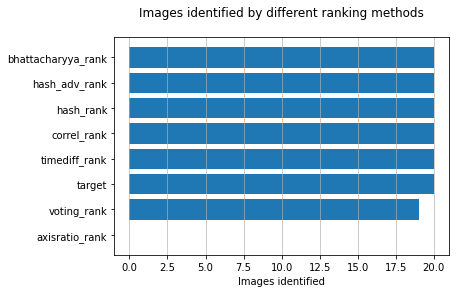

In [13]:
plt.barh(df_eval.index, df_eval['groups_found'])
plt.xlim([df_eval['groups_found'].min()-1, df_eval['groups_found'].max()+1])
plt.grid(which='major', axis='x', alpha=0.8)
plt.xlabel('Images identified')
plt.title('Images identified by different ranking methods\n')

Text(0.5, 1.0, 'Reduction by different ranking methods\n')

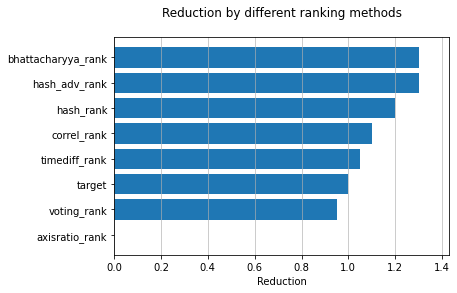

In [15]:
plt.barh(df_eval.index, df_eval['reduction'])
plt.xlim([df_eval['reduction'].min()*0.9, df_eval['reduction'].max()*1.1])
plt.grid(which='major', axis='x', alpha=0.8)
plt.xlabel('Reduction')
plt.title('Reduction by different ranking methods\n')

# Identify the best images: high-pass filtering

In [16]:
df['magnitude_spectrum_f'] = df['gray_images'].apply(lambda x: sc.high_pass_filtering(x))

# Apply results

In [15]:
# Finally, copy the images into ready-to-go directory, that's it!

sc.copy_images(df, (IMAGES, IMAGES_PROCESSED), 'voting_rank', 'magnitude_spectrum_f')

# Hereafter: WIP

# Deep-dive: Hashing

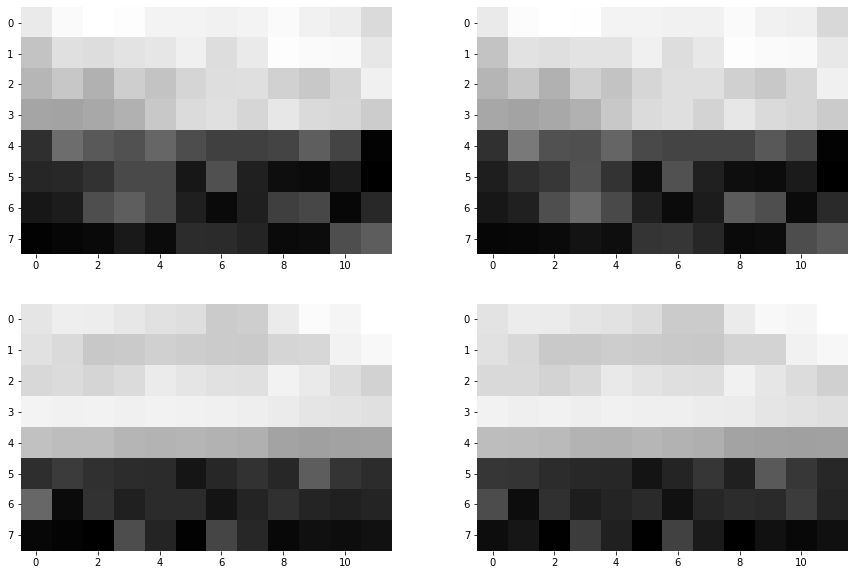

In [329]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.subplot(221, frame_on=False)
plt.imshow(sc.hash_image(df['gray_images'].iloc[0]), cmap='gray')
plt.subplot(222, frame_on=False)
plt.imshow(sc.hash_image(df['gray_images'].iloc[1]), cmap='gray')
plt.subplot(223, frame_on=False)
plt.imshow(sc.hash_image(df['gray_images'].iloc[2]), cmap='gray')
plt.subplot(224, frame_on=False)
plt.imshow(sc.hash_image(df['gray_images'].iloc[3]), cmap='gray')

# Rotate

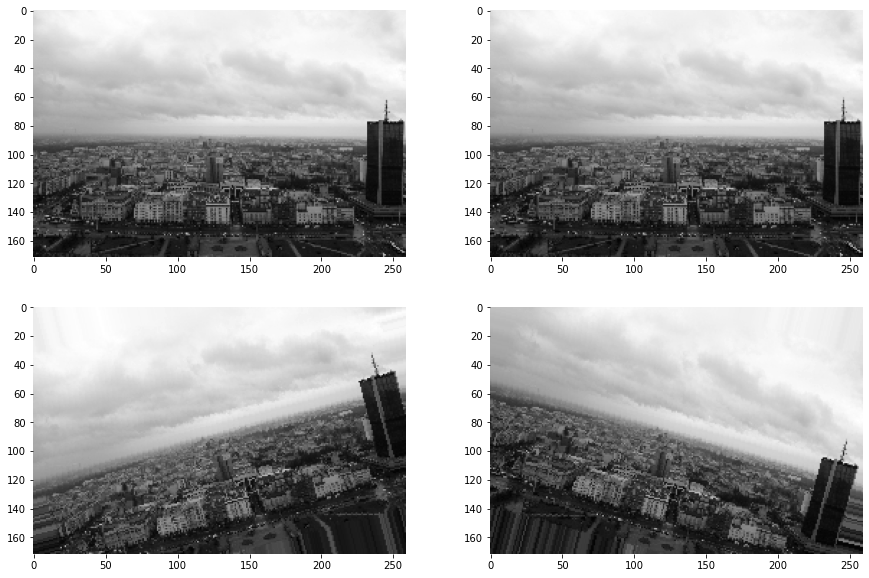

In [330]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.subplot(221, frame_on=False)
plt.imshow(df['gray_images'].iloc[0], cmap='gray')
plt.subplot(222, frame_on=False)
plt.imshow(df['gray_images'].iloc[1], cmap='gray')

plt.subplot(223, frame_on=False)
plt.imshow(sc.rotate_img(df['gray_images'].iloc[1], 15), cmap='gray')
plt.subplot(224, frame_on=False)
plt.imshow(sc.rotate_img(df['gray_images'].iloc[1], -15), cmap='gray')

# Warp images

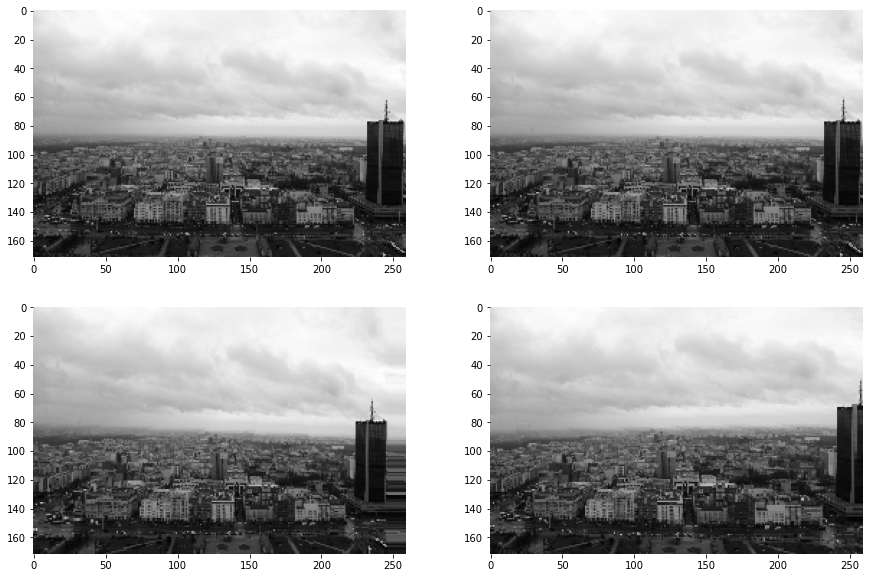

In [331]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.subplot(221, frame_on=False)
plt.imshow(df['gray_images'].iloc[0], cmap='gray')
plt.subplot(222, frame_on=False)
plt.imshow(df['gray_images'].iloc[1], cmap='gray')

plt.subplot(223, frame_on=False)
plt.imshow(sc.warp_img(df['gray_images'].iloc[1], 0.05, how='left'), cmap='gray')
plt.subplot(224, frame_on=False)
plt.imshow(sc.warp_img(df['gray_images'].iloc[1], 0.05, how='right'), cmap='gray')

# Find default values for limits

In [82]:
def bootstrap_data(df, n_runs=10):
    """
    This function shuffles the input data and repeatedly calculates the
    ranks using a variety of methods. This provides better estimates on
    the average values for both image groups (similar or non-similar).
    
    Parameters:
    ------------------------------
        df: (pandas DataFrame), dataframe containing at least the following columns:
            target, creation_date, hash_value, correl_corr, bhattacharyya_corr
            
        n_runs: (int), how often the experiment is repeated

    Returns:
    ------------------------------
        list of pandas DataFrames
    """
    true_targets = df['target'].copy()
    targets = np.arange(0, len(true_targets.unique()))

    runs = []
    for i in range(n_runs):
        np.random.seed(i)
        new_targets = np.random.choice(targets, size=len(targets), replace=False)
        
        # add some "randomness" by reversing images of each group
        if i % 2 == 0:
            df.sort_values(['creation_date'], inplace=True)
        else:
            df.sort_values(['creation_date'], ascending=False, inplace=True)
            
        df['target'] = true_targets.map(dict(zip(targets, new_targets)))
        df.sort_values(['target'], inplace=True)
        
        df['hash_value'] = sc.compare_hashes_adv(df['gray_images'].tolist(),
                                                 return_hash_only=True)
        df['correl_corr'] = sc.calc_correlations(df['hsv_images'].tolist(),
                                                 'correl')
        df['bhattacharyya_corr'] = sc.calc_correlations(df['hsv_images'].tolist(), 
                                                'bhattacharyya')
        
        runs.append(df[['target', 'creation_date', 
                        'hash_value', 'correl_corr', 'bhattacharyya_corr']])
    return runs

def return_distribution(data, _type=None, target_col=None, comp_col=None):
    """
    #TODO: DOCSTRING
    """
    if _type == 'first':
        firsts = []
        for cur_res in data:
            #TODO: calculate mean of element [0,n-1] if group size > 2
            rel_rows = (cur_res.groupby([target_col])[comp_col].agg('count') > 1).values
            firsts.append(cur_res.groupby([target_col])[comp_col].first().iloc[rel_rows])
        firsts = np.sort(np.array(firsts).reshape(-1))
        return firsts
    
    elif _type == 'last':
        lasts = np.sort(np.array([cur_res.groupby([target_col])[comp_col].last().values 
                  for cur_res in data]).reshape(-1))
        return lasts
    
def plot_distributions(dfirst, dlast, bins=10, labels=('x', 'y'), title=''):
    """
    #TODO: DOCSTRING
    """
    xmin, xmax = min(np.append(dfirst, dlast)), max(np.append(dfirst, dlast))
    margin = (xmax-xmin)*0.1
    xrange = np.arange(xmin - margin*2, xmax + margin*2, 0.01)
        
    plt.figure(figsize=(15, 5))
    kde_first = sts.gaussian_kde(dfirst)
    plt.hist(dfirst, bins=bins, rwidth=0.9, density=True, label='first', color='gold', alpha=0.7);
    plt.plot(xrange, kde_first(xrange), lw=2, ls='-', color='#6666ff', label='first-KDE')

    kde_last = sts.gaussian_kde(dlast)
    plt.hist(dlast, bins=bins, rwidth=0.9, density=True, label='last', color='gray', alpha=0.7);
    plt.plot(xrange, kde_last(xrange), lw=2, ls='-', color='#ff6666', label='last-KDE')
    
    plt.xlim([xmin - margin*2, xmax + margin*2])
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()
    
def performance_report(dfirst, dlast, add_std=False):
    """
    #TODO: DOCSTRING
    """
    def precision_score(tp, fp, eps=1e-10):
        return (tp + eps) / (tp + fp + eps) 
    
    def recall_score(tp, fn, eps=1e-10):
        return (tp + eps) / (tp + fn + eps)
    
    def f1_score(tp, fp, fn, eps=1e-10):
        return 2 / (1/precision_score(tp, fp) + 1/recall_score(tp, fn))
    
    limit = dfirst.mean()
    if add_std is True:
        limit += dfirst.std()
        
    tp = sum([1 for c in dfirst if c >= limit])
    fn = len(dfirst) - tp
    tn = sum([1 for c in dlast if c < limit])
    fp = len(dlast) - tn

    print('Performance report\n'+'-'*50)
    print('True positive: {} -- False negative: {}'.format(tp, fn))
    print('True negative: {} -- False positive: {}'.format(tn, fp))
    print('\nPrecision score: {:.4f}'.format(precision_score(tp, fp)))
    print('Recall score: {:.4f}'.format(precision_score(tp, fn)))
    print('F1 score: {:.4f}'.format(f1_score(tp, fp, fn)))

In [83]:
res = bootstrap_data(df, n_runs=10)

# For Hashing

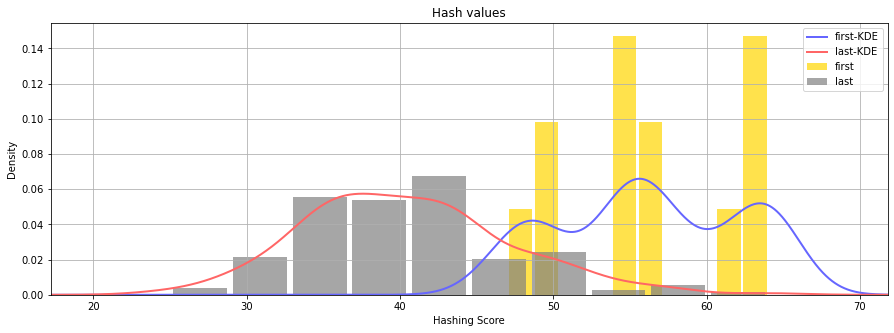

Mean value for groups: 56.33 +- 5.79
Mean value for non-groups: 40.42 +- 6.65


In [84]:
lasts = return_distribution(res, _type='last', target_col='target', comp_col='hash_value')
firsts = return_distribution(res, _type='first', target_col='target', comp_col='hash_value')

plot_distributions(firsts, lasts, labels=('Hashing Score', 'Density'), title='Hash values')

print('Mean value for groups: {:.2f} +- {:.2f}'.format(firsts.mean(), firsts.std()))
print('Mean value for non-groups: {:.2f} +- {:.2f}'.format(lasts.mean(), lasts.std()))

In [85]:
performance_report(firsts, lasts)

Performance report
--------------------------------------------------
True positive: 60 -- False negative: 60
True negative: 185 -- False positive: 5

Precision score: 0.9231
Recall score: 0.5000
F1 score: 0.6486


In [86]:
performance_report(firsts, lasts, add_std=True)

Performance report
--------------------------------------------------
True positive: 30 -- False negative: 90
True negative: 189 -- False positive: 1

Precision score: 0.9677
Recall score: 0.2500
F1 score: 0.3974


# For Bhattacharyya correlation

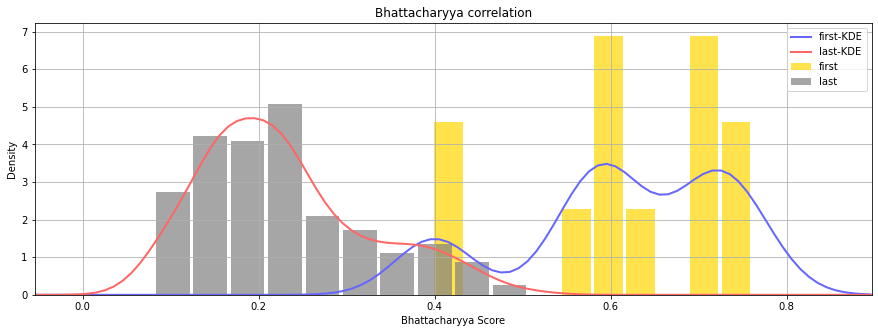

Mean value for groups: 0.61 +- 0.12
Mean value for non-groups: 0.23 +- 0.09


In [87]:
lasts_corr = return_distribution(res, _type='last', target_col='target', comp_col='bhattacharyya_corr')
firsts_corr = return_distribution(res, _type='first', target_col='target', comp_col='bhattacharyya_corr')

plot_distributions(firsts_corr, lasts_corr, labels=('Bhattacharyya Score', 'Density'),
                   title='Bhattacharyya correlation')

print('Mean value for groups: {:.2f} +- {:.2f}'.format(firsts_corr.mean(), firsts_corr.std()))
print('Mean value for non-groups: {:.2f} +- {:.2f}'.format(lasts_corr.mean(), lasts_corr.std()))

In [88]:
performance_report(firsts_corr, lasts_corr)

Performance report
--------------------------------------------------
True positive: 60 -- False negative: 60
True negative: 190 -- False positive: 0

Precision score: 1.0000
Recall score: 0.5000
F1 score: 0.6667


In [89]:
performance_report(firsts_corr, lasts_corr, add_std=True)

Performance report
--------------------------------------------------
True positive: 20 -- False negative: 100
True negative: 190 -- False positive: 0

Precision score: 1.0000
Recall score: 0.1667
F1 score: 0.2857


# For plain correlation

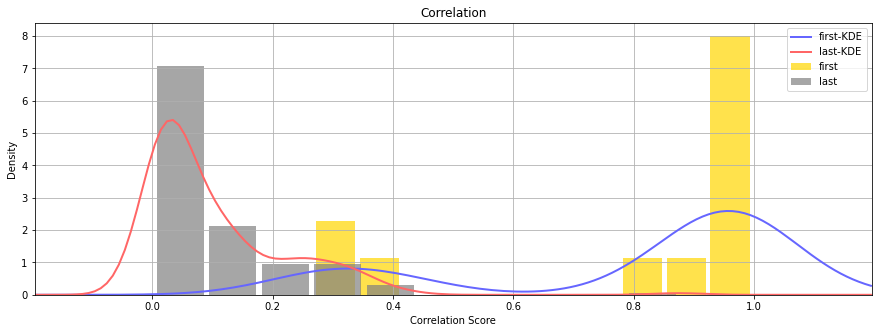

Mean value for groups: 0.80 +- 0.27
Mean value for non-groups: 0.10 +- 0.12


In [90]:
lasts_corr2 = return_distribution(res, _type='last', target_col='target', comp_col='correl_corr')
firsts_corr2 = return_distribution(res, _type='first', target_col='target', comp_col='correl_corr')

plot_distributions(firsts_corr2, lasts_corr2, labels=('Correlation Score', 'Density'),
                   title='Correlation')

print('Mean value for groups: {:.2f} +- {:.2f}'.format(firsts_corr2.mean(), firsts_corr2.std()))
print('Mean value for non-groups: {:.2f} +- {:.2f}'.format(lasts_corr2.mean(), lasts_corr2.std()))

In [91]:
performance_report(firsts_corr2, lasts_corr2)

Performance report
--------------------------------------------------
True positive: 90 -- False negative: 30
True negative: 189 -- False positive: 1

Precision score: 0.9890
Recall score: 0.7500
F1 score: 0.8531


In [92]:
performance_report(firsts_corr2, lasts_corr2, add_std=True)

Performance report
--------------------------------------------------
True positive: 0 -- False negative: 120
True negative: 190 -- False positive: 0

Precision score: 1.0000
Recall score: 0.0000
F1 score: 0.0000


# Find best dimensions for hashing of images (8, 8) -> (n, m)

In [94]:
def bootstrap_data_hashing(df, n_dims=(8, 64)):
    """
    #TODO: DOCSTRING
    """
    true_targets = df['target'].copy()
    targets = np.arange(0, len(true_targets.unique()))

    runs = []
    for i in range(*n_dims, 1):
        df['hash_value'] = sc.compare_hashes_adv(df['gray_images'], hash_dim=(i, i),
                                                 return_hash_only=True)
        df['hash_rank'] = sc.hash_ranker(df['hash_value'], (i, i))
        df['hash_value'] /= (i*i) 
        runs.append(df[['target', 'creation_date', 'hash_value']])
        
    return runs

def return_distribution_hashing(data, _type=None, target_col=None, comp_col=None):
    """
    #TODO: DOCSTRING
    """
    if _type == 'first':
        firsts = []
        for cur_res in data:
            #TODO: calculate mean of element [0,n-1] if group size > 2
            rel_rows = (cur_res.groupby([target_col])[comp_col].agg('count') > 1).values
            firsts.append(cur_res.groupby([target_col])[comp_col].first().iloc[rel_rows])
            
        return firsts
    
    elif _type == 'last':
        lasts = np.array([cur_res.groupby([target_col])[comp_col].last().values 
                  for cur_res in data])
        
        return lasts

In [95]:
hashings = bootstrap_data_hashing(df)

In [96]:
hashings_dim_first = return_distribution_hashing(hashings, _type='first', target_col='target', comp_col='hash_value')
hashings_dim_last = return_distribution_hashing(hashings, _type='last', target_col='target', comp_col='hash_value')

mean_firsts = np.array([(8+enum, d.mean()) for enum, d in enumerate(hashings_dim_first)])
mean_lasts = np.array([(8+enum, d.mean()) for enum, d in enumerate(hashings_dim_last)])

Text(0, 0.5, 'Mean hash matching')

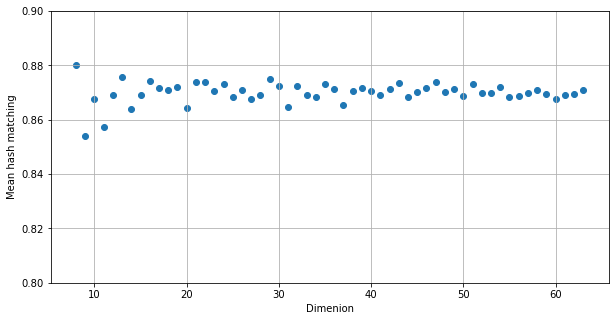

In [97]:
plt.figure(figsize=(10, 5))
plt.scatter(mean_firsts[:,0], mean_firsts[:,1])
plt.ylim([0.8, 0.9])
plt.grid()
plt.xlabel('Dimenion')
plt.ylabel('Mean hash matching')

Text(0, 0.5, 'Mean hash matching')

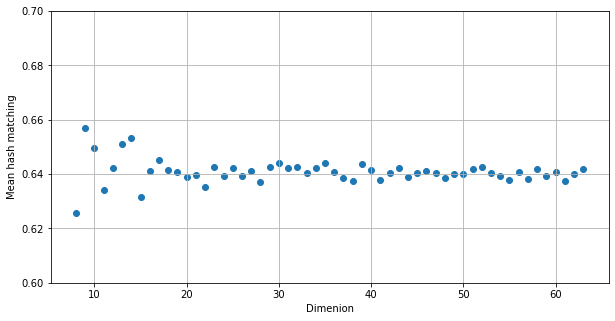

In [98]:
plt.figure(figsize=(10, 5))
plt.scatter(mean_lasts[:,0], mean_lasts[:,1])
plt.ylim([0.6, 0.7])
plt.grid()
plt.xlabel('Dimenion')
plt.ylabel('Mean hash matching')

In [97]:
# mean values seem to be consistent independently of changing hash dimensions 
# and are close to the results obtained from bootstrapping
# potentially, anisotropic changes can yield different variations

56/64, 40/64

(0.875, 0.625)

# A logistic regression fit for limit estimation

In [107]:
def fit_logreg(firsts, lasts, make_plot=True, labels=('x', 'Probability'), limits=None):
    """
    TODO: DOCSTRING
    """
    X_train = np.append(lasts, firsts)
    X_train = np.c_[X_train, np.ones(len(X_train))]
    y_train = np.array(len(lasts)*[0] + len(firsts)*[1])
    
    if limits is None:
        min_val, max_val = min(X_train[:,0]), max(X_train[:,0])
    else:
        min_val, max_val = limits

    lreg = LogisticRegression()
    lreg.fit(X_train, y_train)

    x_vals = np.arange(min_val*0.8, max_val*1.2, 0.001)
    probs = lreg.predict_proba(np.c_[x_vals, np.ones(len(x_vals))])
    lower_bound = np.argmax(probs[probs<=0.50])
    print('Limit at {:.2f}'.format(x_vals[lower_bound]))
    
    if make_plot is True:
        fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True,
                               gridspec_kw={'height_ratios': [5, 1]},
                               tight_layout=True)
        
        for paxis in range(2):
            axs[paxis].plot([x_vals[lower_bound], x_vals[lower_bound]], [-0.1, 1.1], '-',
                 color='gray', alpha=0.5, lw=10)
        
        axs[0].plot(x_vals, probs[:,1], 'b-', label='Probability curve', alpha=0.5)
        
        axs[0].scatter(X_train[y_train==0, 0], lreg.predict_proba(X_train)[y_train==0, 1],
                    marker='.', s=400, ec='gray', label='False', color='red', alpha=.8)
        axs[0].scatter(X_train[y_train==1, 0], lreg.predict_proba(X_train)[y_train==1, 1],
                    marker='.', s=400, ec='gray', label='True', color='green', alpha=.8)
        
        axs[1].eventplot(firsts, lineoffsets=[0.2], linelengths=0.4, linewidths=0.5,
                         orientation='horizontal', color='green', alpha=0.5)
        axs[1].eventplot(lasts, lineoffsets=[0.75], linelengths=0.4, linewidths=0.5,
                         orientation='horizontal', color='red', alpha=0.5)

        axs[0].axis([min_val*0.8, max_val*1.1, -0.1, 1.1])
        axs[0].grid()
        axs[0].legend(loc='upper left')

        xl, yl = labels
        axs[1].set_xlabel(xl)
        axs[0].set_ylabel(yl)
        axs[0].set_title('Logistic regression fit')
        
        axs[1].axis([min_val*0.9, max_val*1.1, -0.1, 1.1])
        axs[1].set_ylabel('Event')
        axs[1].tick_params(labelleft=False)
        axs[1].grid()
        
        plt.show()

Limit at 49.78


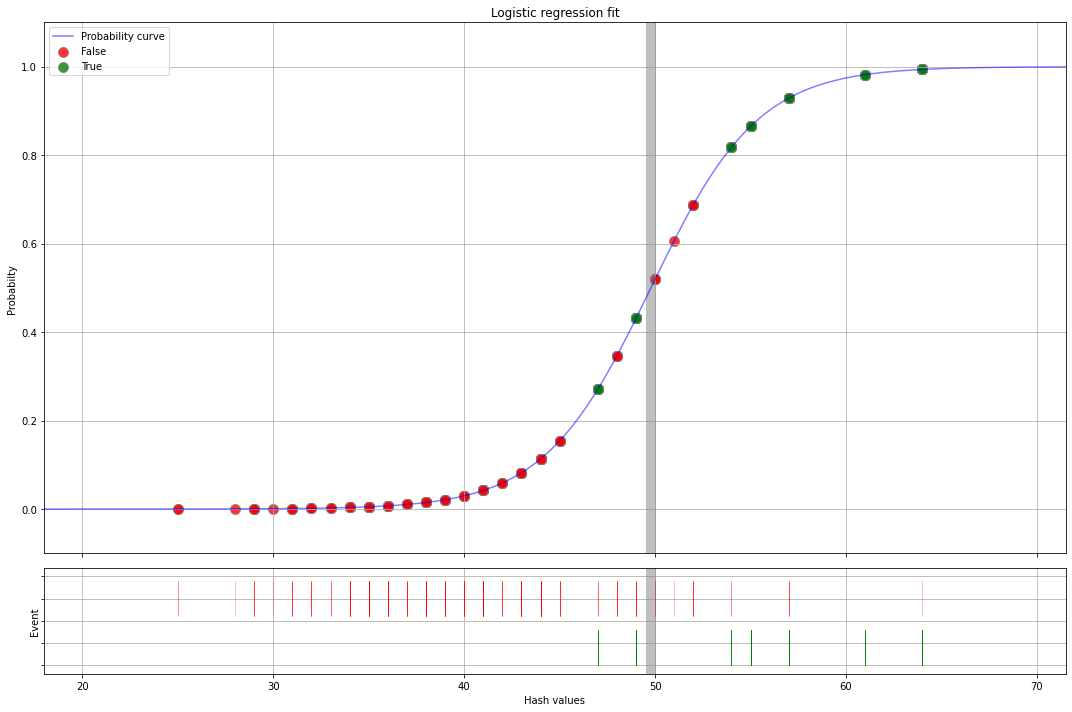

In [108]:
fit_logreg(firsts, lasts, labels=('Hash values', 'Probabilty'), limits=(20, 65))

Limit at 0.46


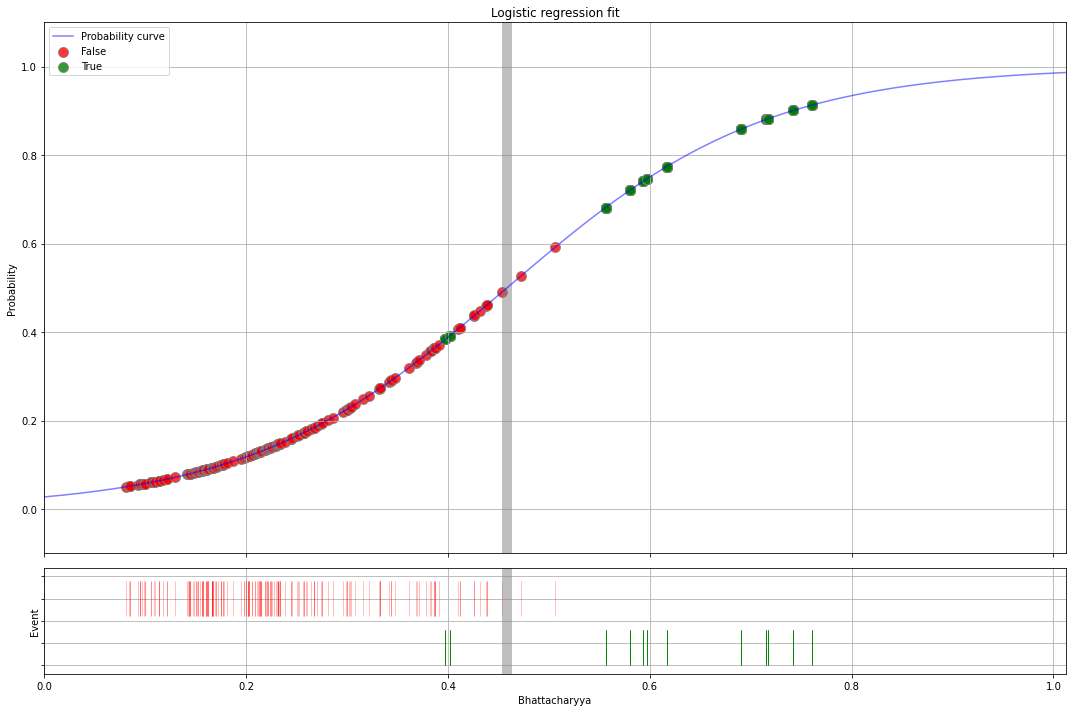

In [113]:
fit_logreg(firsts_corr, lasts_corr, labels=('Bhattacharyya', 'Probability'), limits=(0,0.92))

Limit at 0.45


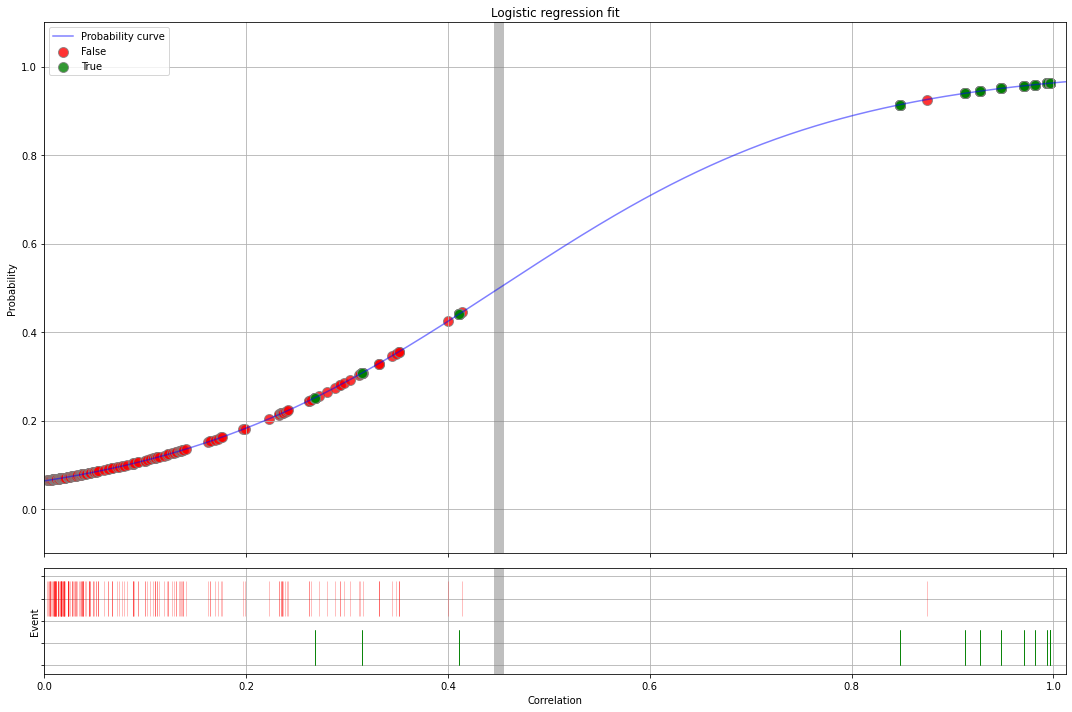

In [112]:
fit_logreg(firsts_corr2, lasts_corr2, labels=('Correlation', 'Probability'), limits=(0,0.92))

# TODO: Entropy for matching

In [ ]:
from scipy.stats import entropy
entropy(df['target'], df['target'])
for i in voting_col + ['target']:
    print(i, entropy(df['target'], df[i]))
df[[c for c in df.columns if not c.endswith('_images')]]

# TODO: Evaluate Advanced Hashing

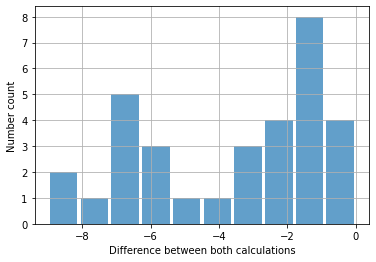

In [292]:
# two groups can be identified: small & larger differences
# small differences seem to be caused by better matching of similar images
# larger differences are rather errorneous correlations
# -> can be used as believable max_change

df['hash_diff'] = df['hash_value'] - df['hash_adv_value']

plt.hist((df['hash_value'] - df['hash_adv_value']), bins=10, rwidth=0.9, alpha=0.7);
plt.xlabel('Difference between both calculations')
plt.ylabel('Number count')
plt.grid()

# Deep-dive: high-pass filtering

In [ ]:
grouped = df.groupby(['target']).agg(mag_mean=('magnitude_spectrum', np.mean),
            mag_std=('magnitude_spectrum', np.std))

grouped = grouped.loc[grouped['mag_std'].notna(), :]
grouped.head()